In [1]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D,Input,MaxPooling2D,Dropout,Flatten,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


# Facial landmark detection with Keras CNN

In this kernel I used Keras to make a simple convolutional neural network (CNN) to detect the eyes, nose and mouth from this database.

In [2]:
# load the dataset
images = np.moveaxis(np.load('./dataset/archive/face_images.npz')['face_images'], -1, 0)
landmarks = pd.read_csv('./dataset/archive/facial_keypoints.csv')

landmarks_pos = landmarks.columns.tolist()
print(landmarks.isnull().sum())

/tmp/ipykernel_17310/1253735854.py:2: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  images = np.moveaxis(np.load('./dataset/archive/face_images.npz')['face_images'], -1, 0)


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

I will only select the x and y of the eyes center, nose tip and mouth center, because these values are most avaiable. This gives 7000 images and X and Y are build to fit Keras format. Y is rescaled between 0 and 1.

In [3]:
index_nn = np.nonzero(landmarks.left_eye_center_x.notna() & landmarks.right_eye_center_x.notna())[0]

pic_shape = images.shape[1]
m = index_nn.shape[0]
X = np.zeros((m,pic_shape,pic_shape,1))
Y = np.zeros((m,12))

X[:,:,:,0]=images[index_nn,:,:]/255.0

Y[:,0]=landmarks.left_eye_center_x[index_nn]
Y[:,1]=landmarks.left_eye_center_y[index_nn]
Y[:,2]=landmarks.right_eye_center_x[index_nn]
Y[:,3]=landmarks.right_eye_center_y[index_nn]

Y[:,4]=landmarks.left_eye_inner_corner_x[index_nn]
Y[:,5]=landmarks.left_eye_inner_corner_y[index_nn]
Y[:,6]=landmarks.left_eye_outer_corner_x[index_nn]
Y[:,7]=landmarks.left_eye_outer_corner_y[index_nn]

Y[:,8]=landmarks.right_eye_inner_corner_x[index_nn]
Y[:,9]=landmarks.right_eye_inner_corner_y[index_nn]
Y[:,10]=landmarks.right_eye_outer_corner_x[index_nn]
Y[:,11]=landmarks.right_eye_outer_corner_y[index_nn]

print('# selected images = %d' % m)

# selected images = 7033


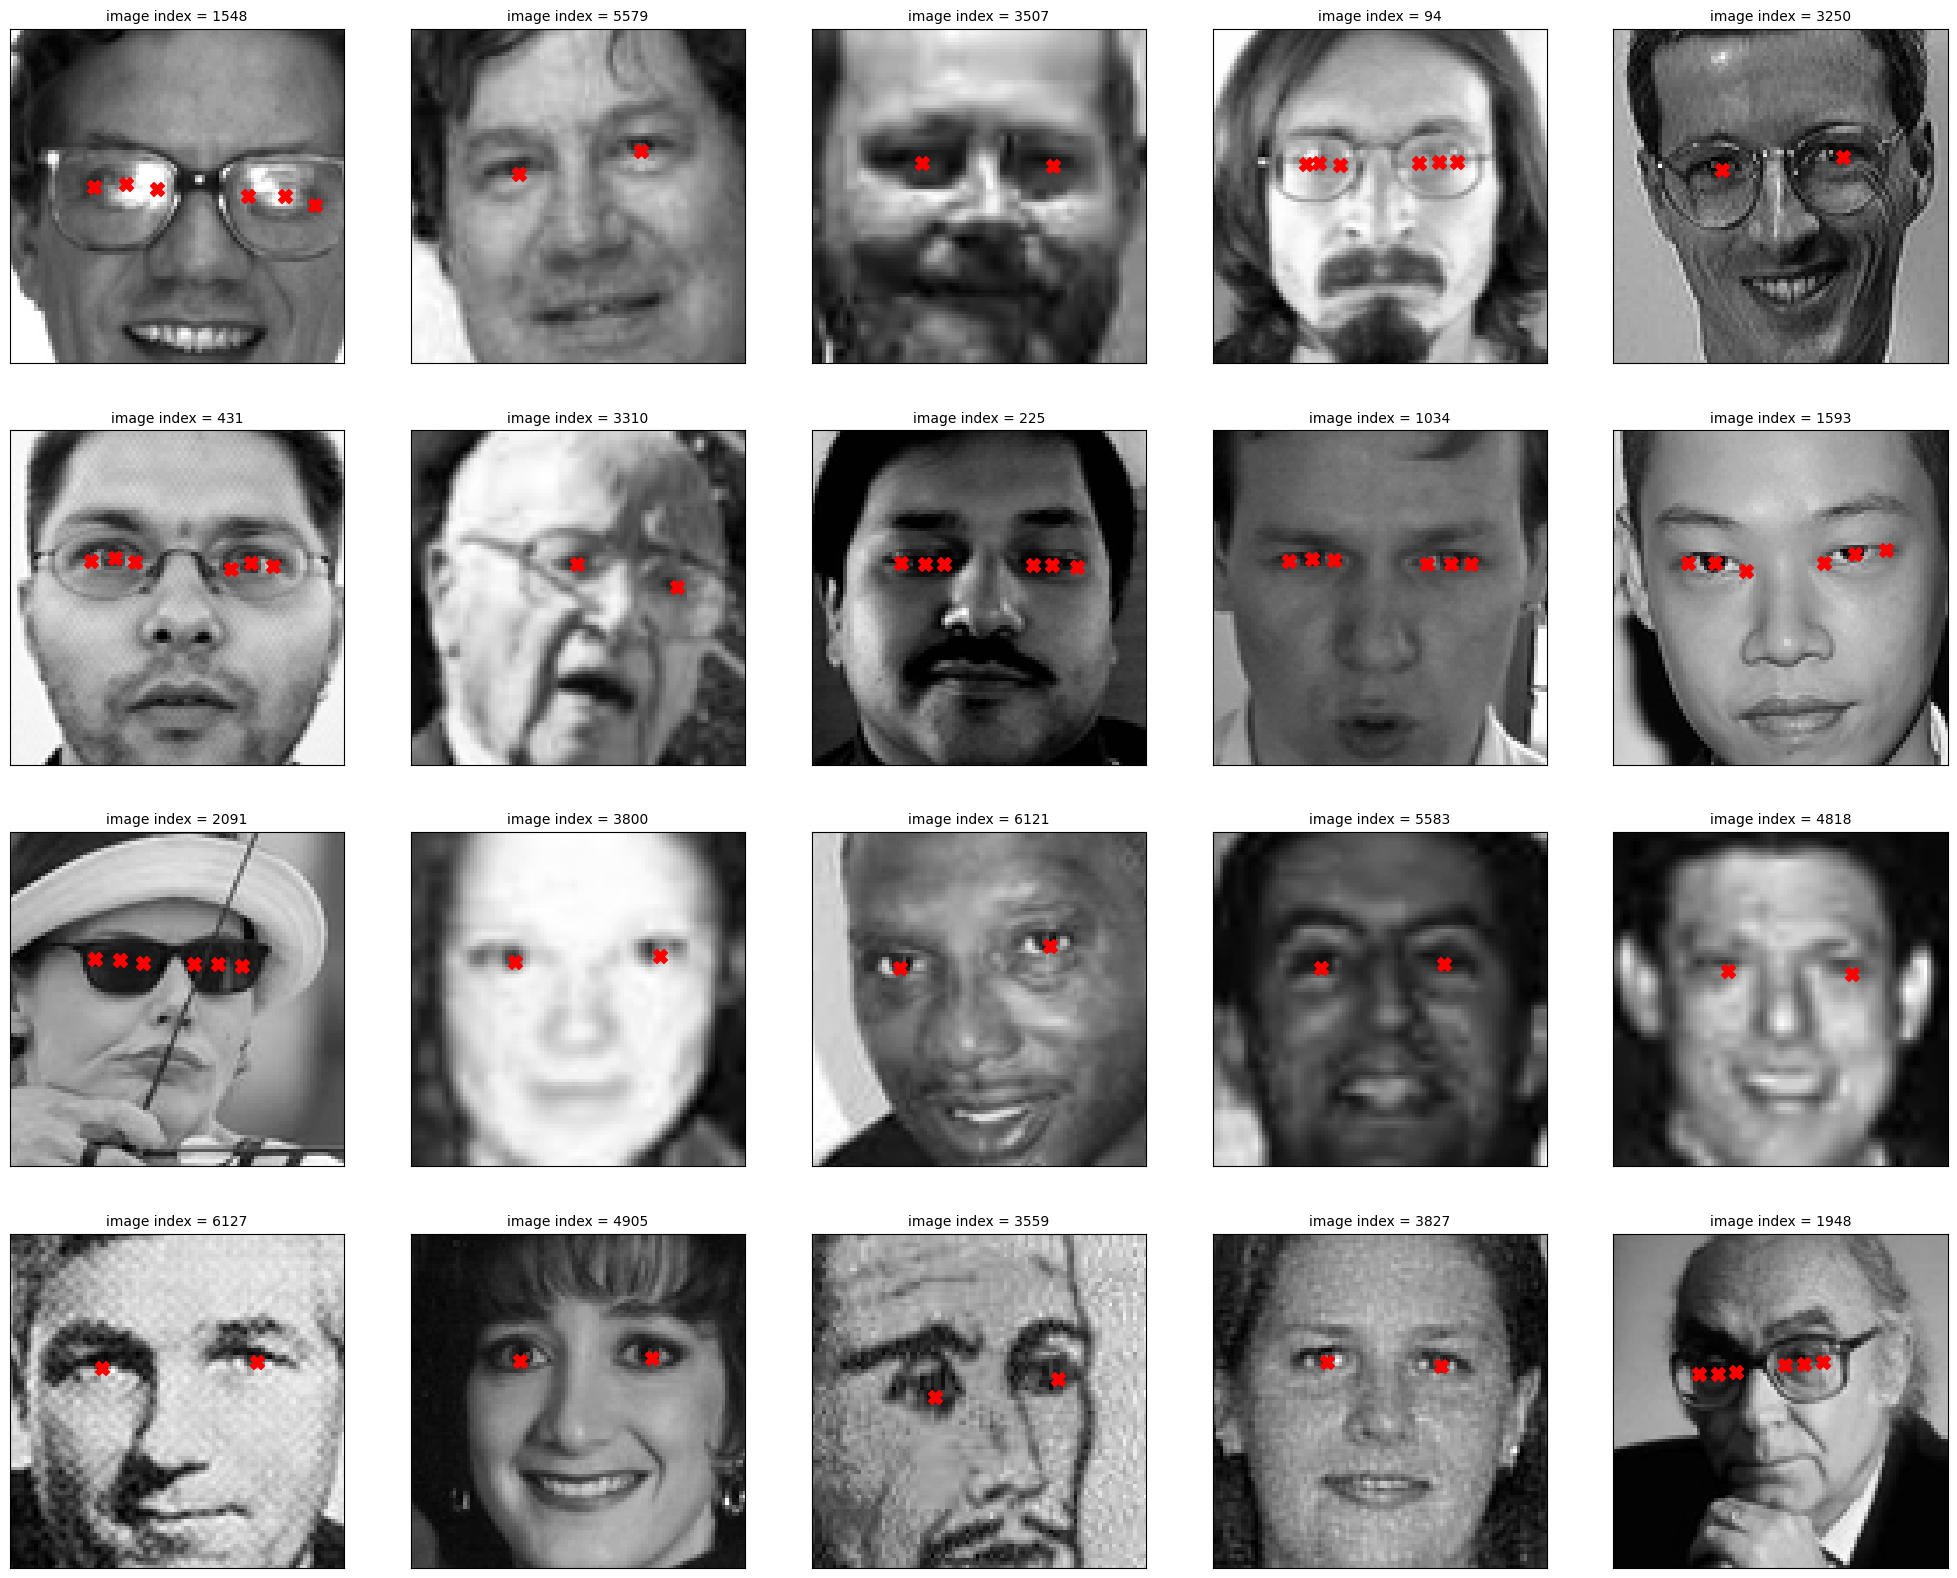

In [4]:
def plot_sample(X, Y, n_rows, n_cols, size=3):
    # sample n_rows*n_cols images
    i_rand = np.random.choice(Y.shape[0],n_rows*n_cols)
    n = 0
    fig, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True,figsize=[n_cols*size,n_rows*size])
    for row in range(n_rows):
        for col in range(n_cols):
            ax[row,col].imshow(X[i_rand[n],:,:,0], cmap='gray')
            ax[row,col].scatter(Y[i_rand[n],0::2],Y[i_rand[n],1::2],marker='X',c='r',s=100)
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' % i_rand[n], fontsize=10)
            n += 1

plot_sample(X, Y, 4, 5, 5)

As we can see there are a lot of missing values in the dataset. Let's try to fill them using some methods. 

In [5]:
# Normalize the dataset
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

# Fit the KNN imputer model on the normalized data
imputer = KNNImputer(n_neighbors=11)
Y_imputed = imputer.fit_transform(Y_scaled)

# Combine the imputed and non-missing parts of the dataset
Y = scaler.inverse_transform(Y_imputed)

Let's see how the data looks like after imputation.

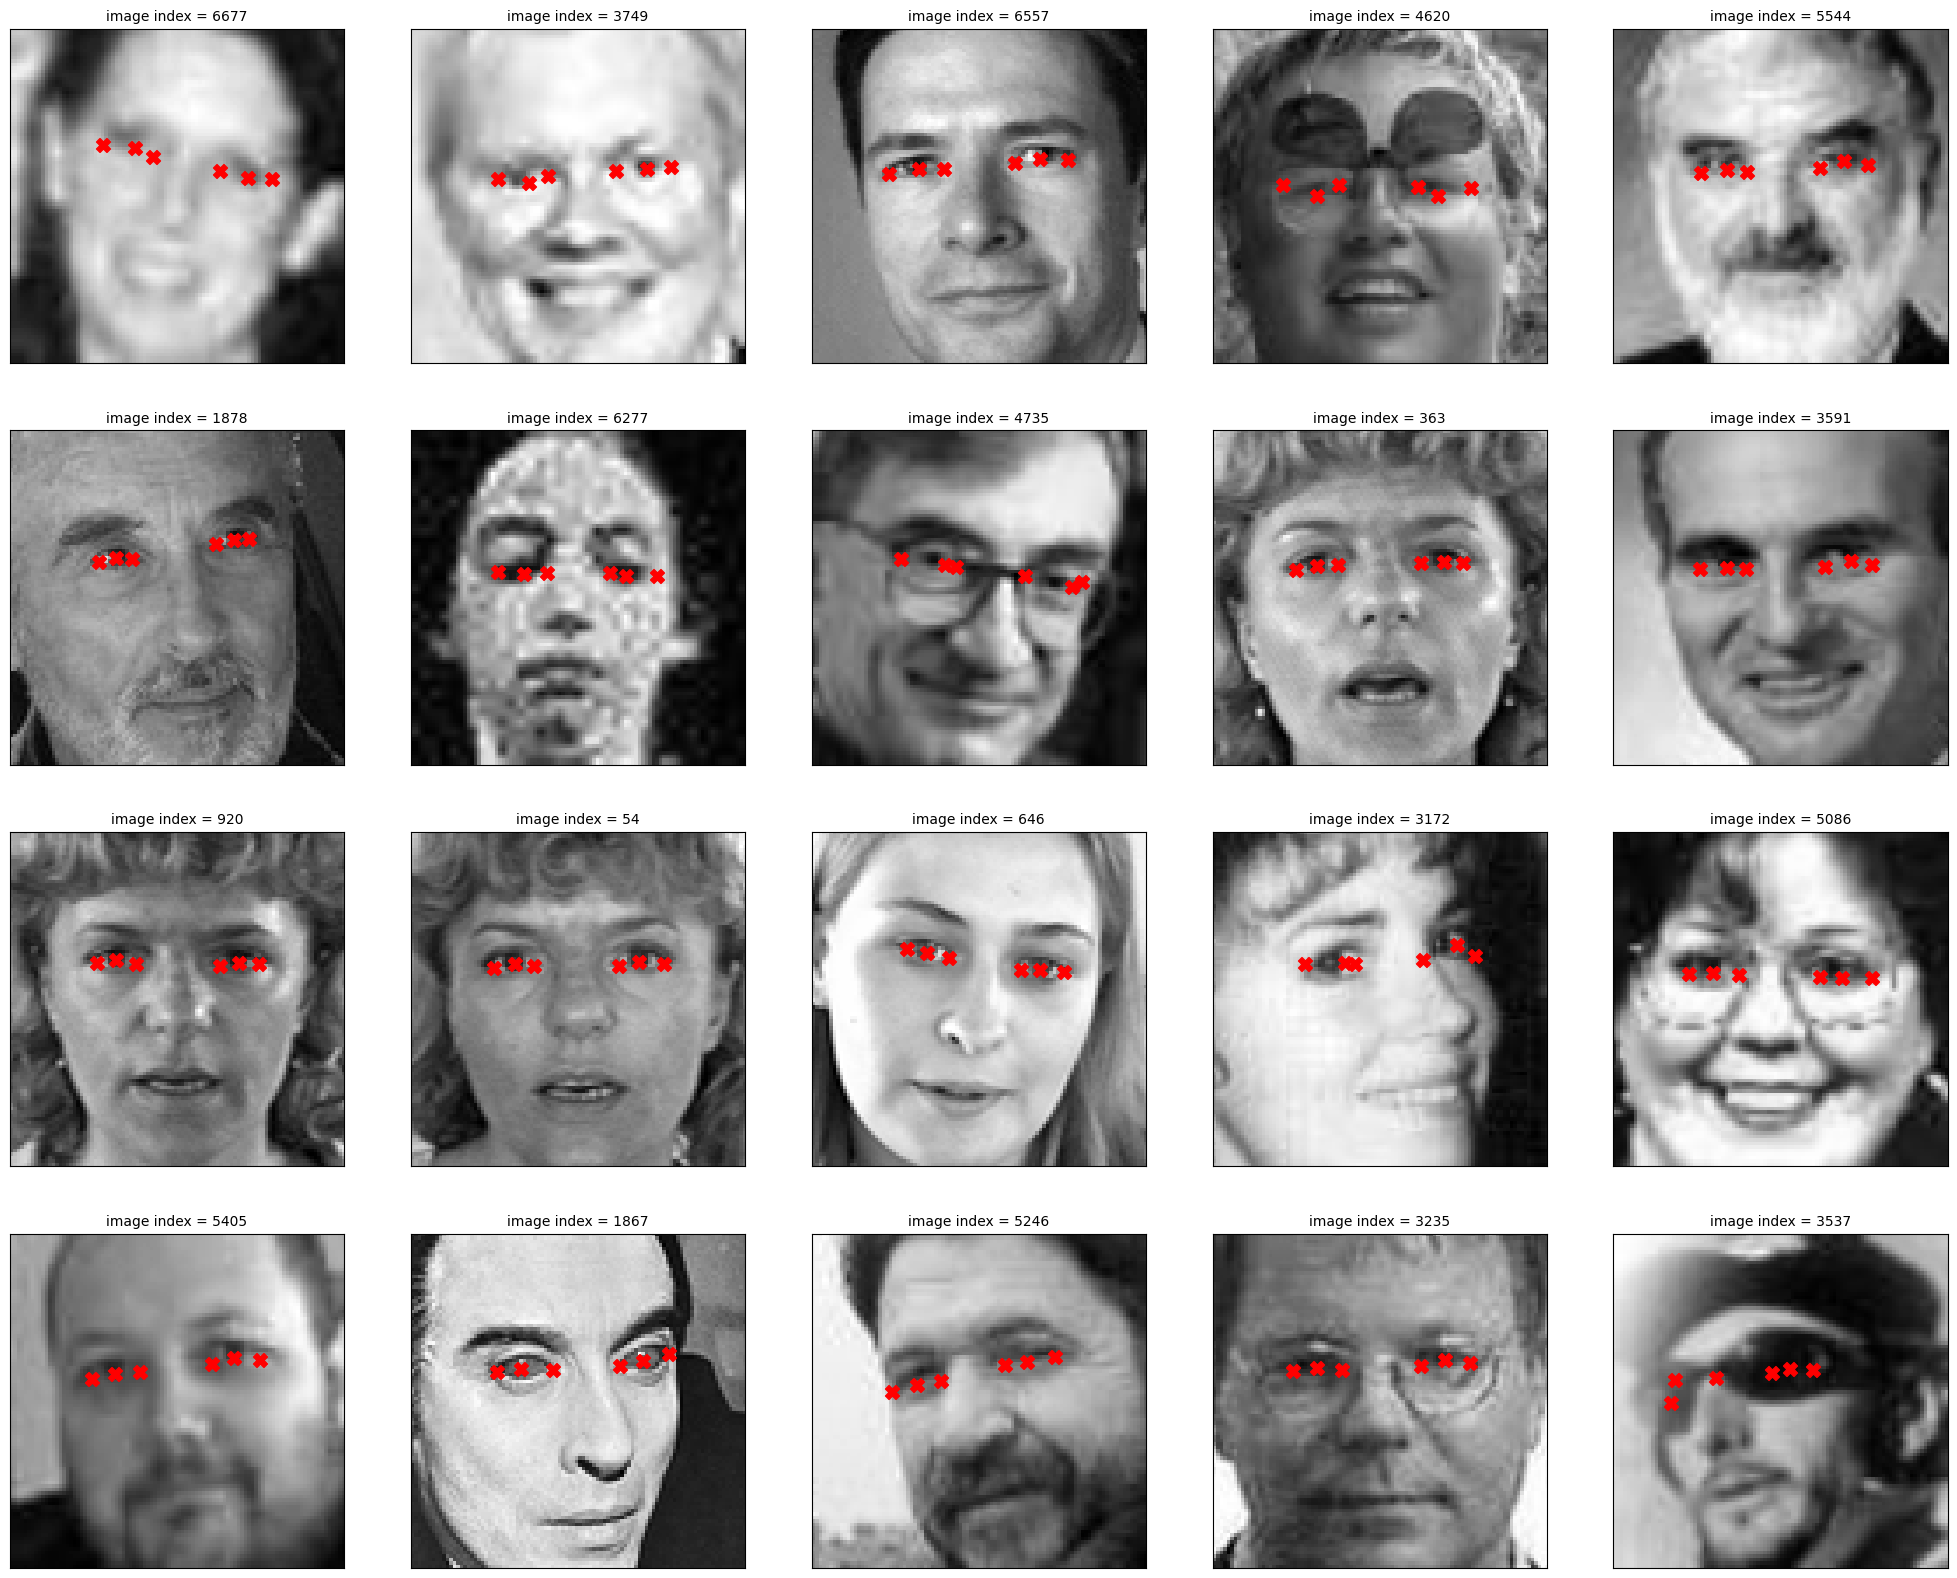

In [6]:
plot_sample(X, Y, 4, 5, 5)

## Data augmentation

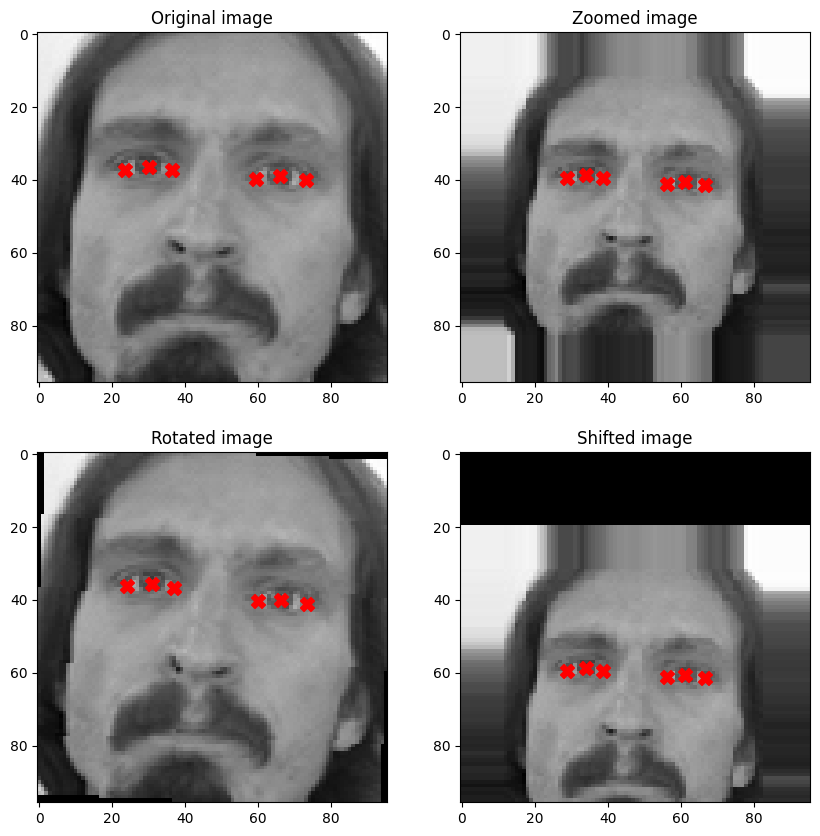

In [7]:
import cv2

# random zoom, fill mode is border replicate 
def random_zoom_out(image, landmarks, zoom_range=(0.5, 1.0)):
    zoom = np.random.uniform(zoom_range[0], zoom_range[1])
    new_size = (int(image.shape[1] * zoom), int(image.shape[0] * zoom))
    diff = np.abs(new_size[0] - image.shape[1]) // 2
        
    image_zoomed = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

    diff_2 = diff_3 = diff if np.abs(new_size[0] - image.shape[1]) % 2 == 0 else diff + 1

    image_zoomed = cv2.copyMakeBorder(image_zoomed, diff, diff_2, diff, diff_3, cv2.BORDER_REPLICATE)
    landmarks_zoomed = landmarks * new_size[0] / image.shape[1] + diff
    
    if image_zoomed.shape[0] != 96 or image_zoomed.shape[1] != 96:
        print('image_zoomed shape:', image_zoomed.shape)
    
    return image_zoomed, landmarks_zoomed

# random rotation
def random_rotation(image, landmarks, angle_range=(-10, 10)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    image_rotated = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
    
    landmarks_rotated = np.copy(landmarks)
    for i in range(0, len(landmarks), 2):
        x = landmarks[i]
        y = landmarks[i + 1]
        landmarks_rotated[i] = rot_mat[0, 0] * x + rot_mat[0, 1] * y + rot_mat[0, 2]
        landmarks_rotated[i + 1] = rot_mat[1, 0] * x + rot_mat[1, 1] * y + rot_mat[1, 2]
    
    return image_rotated, landmarks_rotated

# random shift, choose a random shift value and a random direction
def random_shift(image, landmarks, shift_range=(0, 20)):
    shift = int(np.random.uniform(shift_range[0], shift_range[1]))
    direction = np.random.choice(['left', 'right', 'up', 'down'])
    
    if direction == 'left':
        shift_x = -shift
        shift_y = 0
    elif direction == 'right':
        shift_x = shift
        shift_y = 0
    elif direction == 'up':
        shift_x = 0
        shift_y = -shift
    else:
        shift_x = 0
        shift_y = shift
    
    shift_mat = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    image_shifted = cv2.warpAffine(image, shift_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
    
    landmarks_shifted = np.copy(landmarks)
    for i in range(0, len(landmarks), 2):
        landmarks_shifted[i] += shift_x
        landmarks_shifted[i + 1] += shift_y
    
    return image_shifted, landmarks_shifted

# examples
image = X[0]
landmarks = Y[0]
image_zoomed, landmarks_zoomed = random_zoom_out(image, landmarks, zoom_range=(0.7, 0.9))
image_rotated, landmarks_rotated = random_rotation(image, landmarks, angle_range=(-30, 30))
image_shifted, landmarks_shifted = random_shift(image_zoomed, landmarks_zoomed, shift_range=(0, 30))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image[:,:,0], cmap='gray')
ax[0][0].scatter(landmarks[0::2], landmarks[1::2], marker='X', c='r', s=100)
ax[0][0].set_title('Original image')

ax[0][1].imshow(image_zoomed, cmap='gray')
ax[0][1].scatter(landmarks_zoomed[0::2], landmarks_zoomed[1::2], marker='X', c='r', s=100)
ax[0][1].set_title('Zoomed image')

ax[1][0].imshow(image_rotated, cmap='gray')
ax[1][0].scatter(landmarks_rotated[0::2], landmarks_rotated[1::2], marker='X', c='r', s=100)
ax[1][0].set_title('Rotated image')

ax[1][1].imshow(image_shifted, cmap='gray')
ax[1][1].scatter(landmarks_shifted[0::2], landmarks_shifted[1::2], marker='X', c='r', s=100)
ax[1][1].set_title('Shifted image')

plt.show()

apply random zoom and rotation to the dataset

In [8]:
from joblib import Parallel, delayed

# Define a function that performs data augmentation on a single image
def augment_image(image, landmarks):
    image_zoomed, landmarks_zoomed = random_zoom_out(image, landmarks, zoom_range=(0.7, 0.9))
    image_rotated, landmarks_rotated = random_rotation(image, landmarks, angle_range=(-30, 30))
    image_shifted, landmarks_shifted = random_shift(image_zoomed, landmarks_zoomed, shift_range=(-30, 30))

    image_zoomed = np.expand_dims(image_zoomed, axis=2)
    image_rotated = np.expand_dims(image_rotated, axis=2)
    image_shifted = np.expand_dims(image_shifted, axis=2)

    return [image_zoomed, image_rotated, image_shifted], [landmarks_zoomed, landmarks_rotated, landmarks_shifted]

# Use joblib to parallelize the data augmentation
results = Parallel(n_jobs=-1)(delayed(augment_image)(X[i], Y[i]) for i in range(X.shape[0]))

# Extract the results
X_augmented = np.array([result[0] for result in results])
Y_augmented = np.array([result[1] for result in results])

# Flatten the results
X_augmented = np.concatenate(X_augmented, axis=0)
Y_augmented = np.concatenate(Y_augmented, axis=0)

Show the augmented dataset

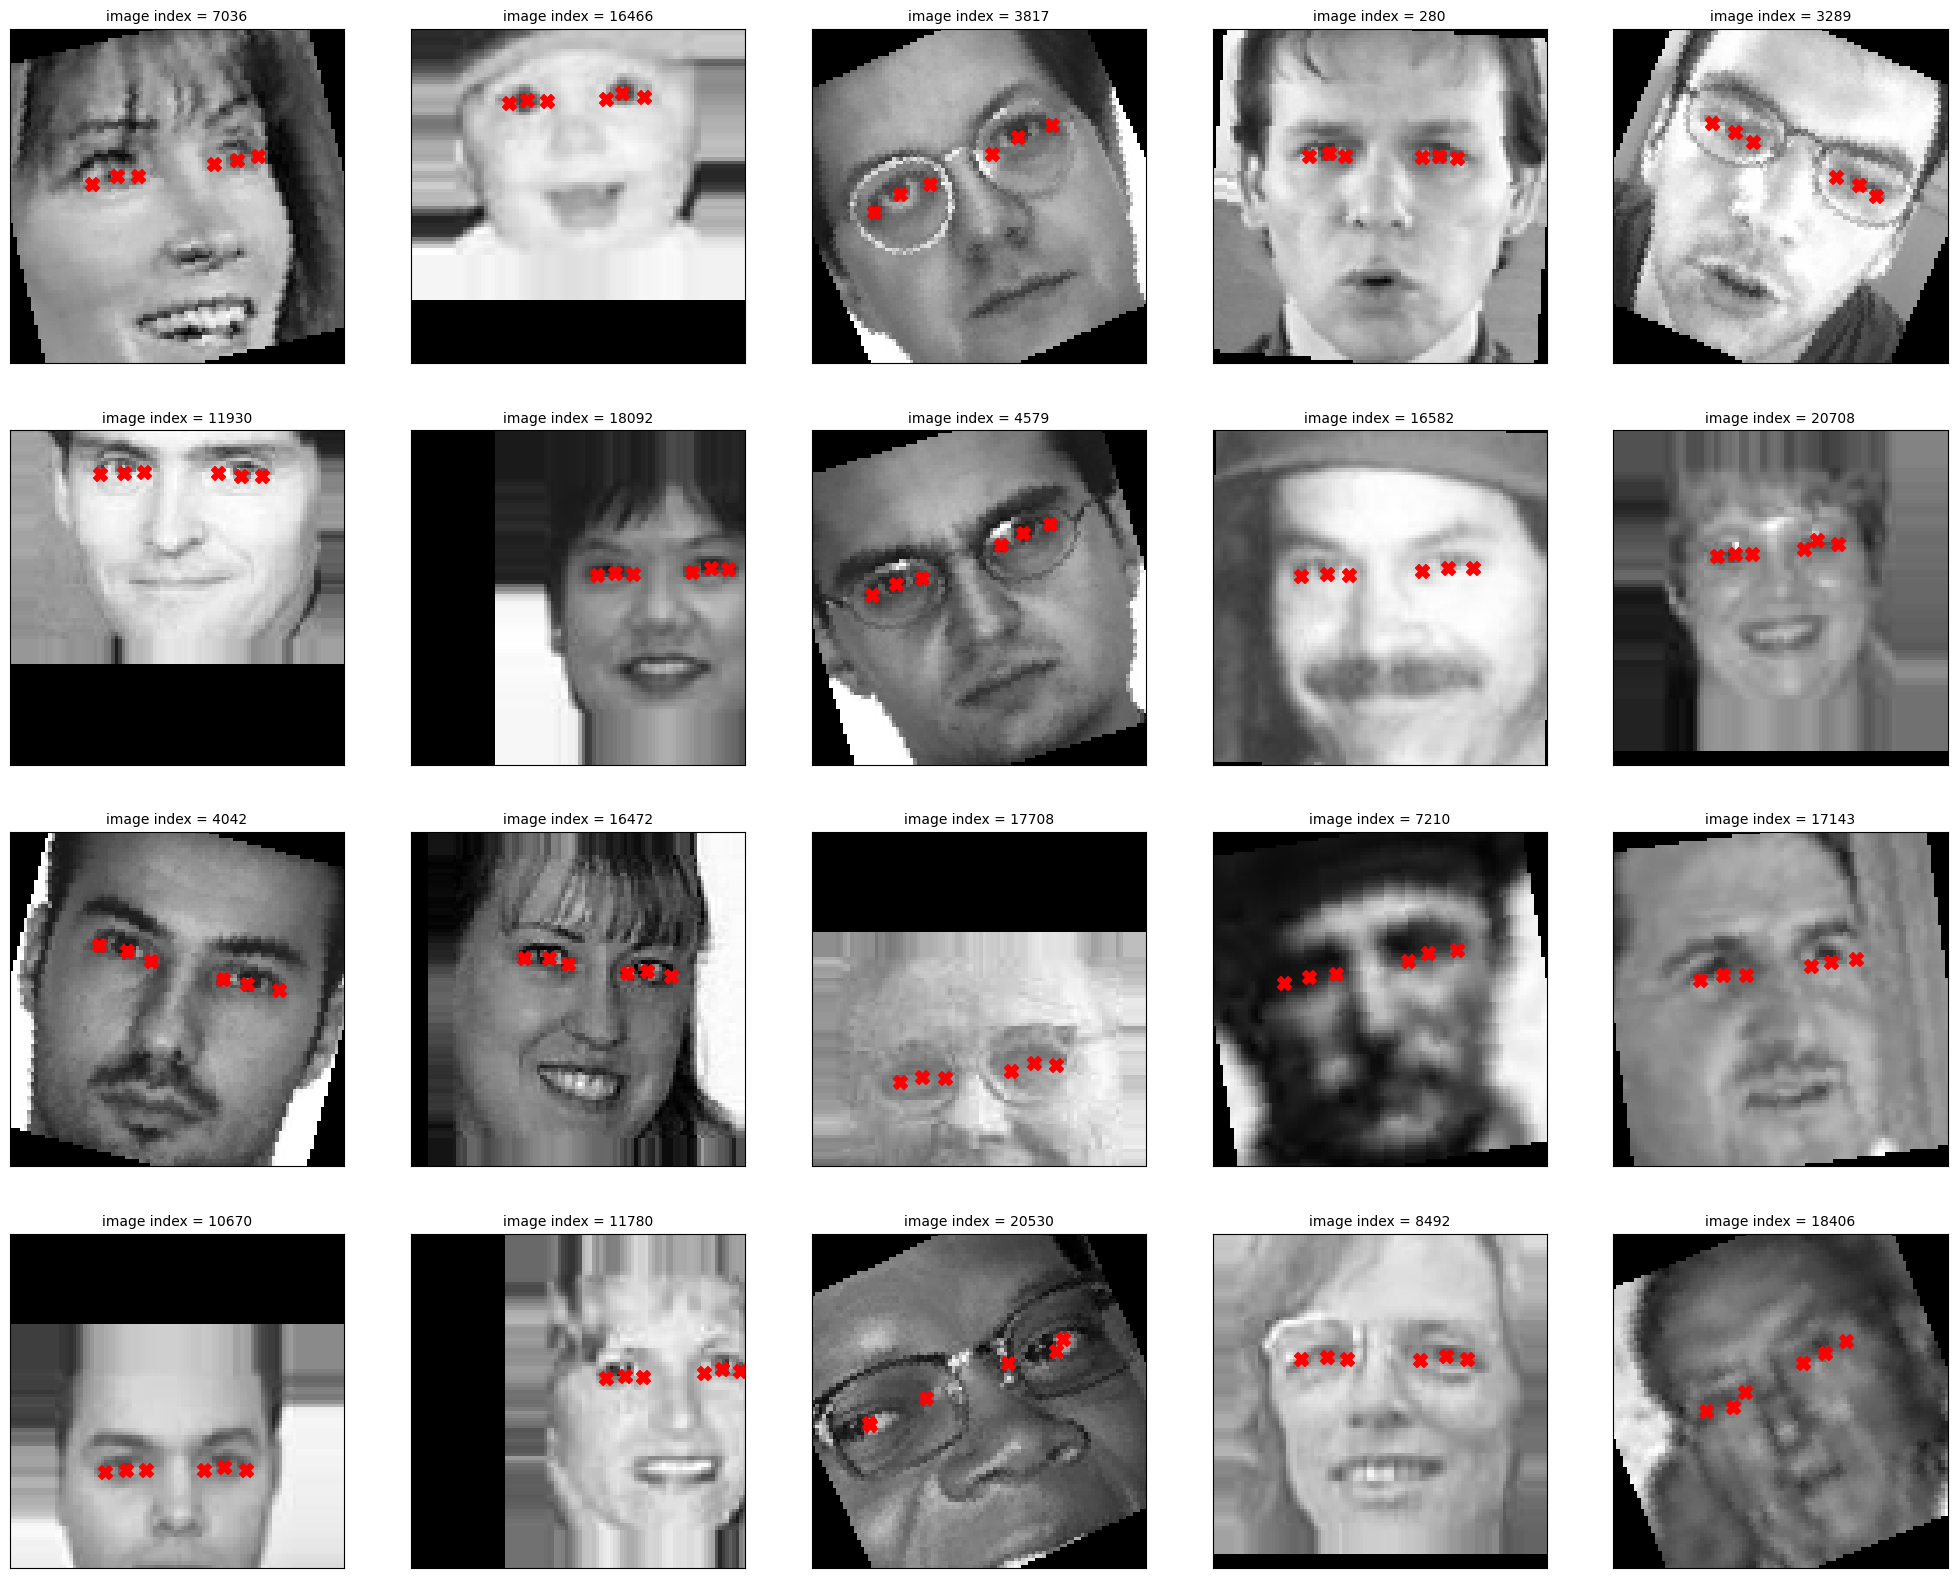

In [9]:
plot_sample(X_augmented, Y_augmented, 4, 5, 5)

## Train, test and validation split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_augmented, Y_augmented, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)

X_train shape: (13503, 96, 96, 1)
Y_train shape: (13503, 12)
X_test shape: (4220, 96, 96, 1)
Y_test shape: (4220, 12)
X_val shape: (3376, 96, 96, 1)
Y_val shape: (3376, 12)


## Model

In [11]:
model = Sequential([
    Input(shape=(96, 96, 1)),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', kernel_initializer=glorot_uniform(), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', kernel_initializer=glorot_uniform(), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', kernel_initializer=glorot_uniform(), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(1028, kernel_initializer=glorot_uniform(), activation='relu'),
    Dropout(0.5),
    Dense(64, kernel_initializer=glorot_uniform(), activation='relu'),
    Dense(12, kernel_initializer=glorot_uniform(), activation='sigmoid')
])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │      1,280 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 96, 96,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 96, 96,    │        256 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 96, 96,    │          0 │ conv2d_1[0][0],   │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 96, 96,    │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48, 48,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │    295,168 │ dropout[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 48, 48,    │     33,024 │ dropout[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 48,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 48,    │          0 │ conv2d_4[0][0],   │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ add_1[0][0]     

 Total params: 23,662,668 (90.27 MB)

 Trainable params: 23,659,084 (90.25 MB)

 Non-trainable params: 3,584 (14.00 KB)

Compile the model

In [12]:
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy', 'mae'])

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    verbose=1, 
    restore_best_weights=True
)

Train the model

In [13]:
history = model.fit(
    X_train, Y_train,
    batch_size=48,
    epochs=80,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/100


I0000 00:00:1718048407.701522   17431 service.cc:145] XLA service 0x723648004f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718048407.701559   17431 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6


  1/282 ━━━━━━━━━━━━━━━━━━━━ 2:53:56 37s/step - accuracy: 0.0417 - loss: 1949.7817 - mae: 41.7896

I0000 00:00:1718048441.664271   17431 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_select_fusion_2', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1718048441.673067   17431 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6104 - loss: 793.9860 - mae: 13.5302

I0000 00:00:1718048501.558634   17427 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_select_fusion_2', 16 bytes spill stores, 16 bytes spill loads



282/282 ━━━━━━━━━━━━━━━━━━━━ 105s 242ms/step - accuracy: 0.6110 - loss: 791.9296 - mae: 13.5093 - val_accuracy: 0.9751 - val_loss: 359.9415 - val_mae: 17.2041
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 49s 176ms/step - accuracy: 0.9327 - loss: 30.0682 - mae: 4.1477 - val_accuracy: 0.9751 - val_loss: 285.1099 - val_mae: 15.3668
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.9596 - loss: 19.3907 - mae: 3.2665 - val_accuracy: 0.9701 - val_loss: 237.7814 - val_mae: 14.5399
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accuracy: 0.9625 - loss: 16.5953 - mae: 2.9885 - val_accuracy: 0.9357 - val_loss: 256.3418 - val_mae: 15.2221
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accuracy: 0.9639 - loss: 15.3578 - mae: 2.8604 - val_accuracy: 0.9570 - val_loss: 249.4425 - val_mae: 14.9796
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accuracy: 0.9671 - loss: 12.4269 - mae: 2.5565 - val_accuracy: 0.9514 - val_loss: 266.1937 - val_mae: 15.2432
E

Plot the loss

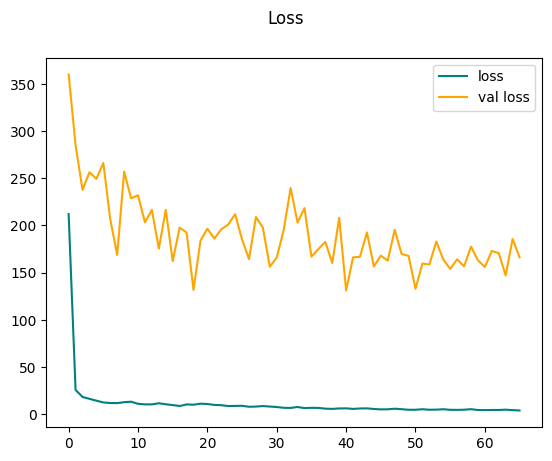

In [14]:
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

Save the model

In [15]:
model.save('./models/facial_landmark_detection.h5')

## Test the model
load the model

In [16]:
model = tf.keras.models.load_model('./models/facial_landmark_detection.h5')
model.evaluate(X_test, Y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.9826 - loss: 130.0495 - mean_absolute_error: 10.6402


[129.3267364501953, 0.9822275042533875, 10.604294776916504]

Let's see how the model performs on the test set.

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


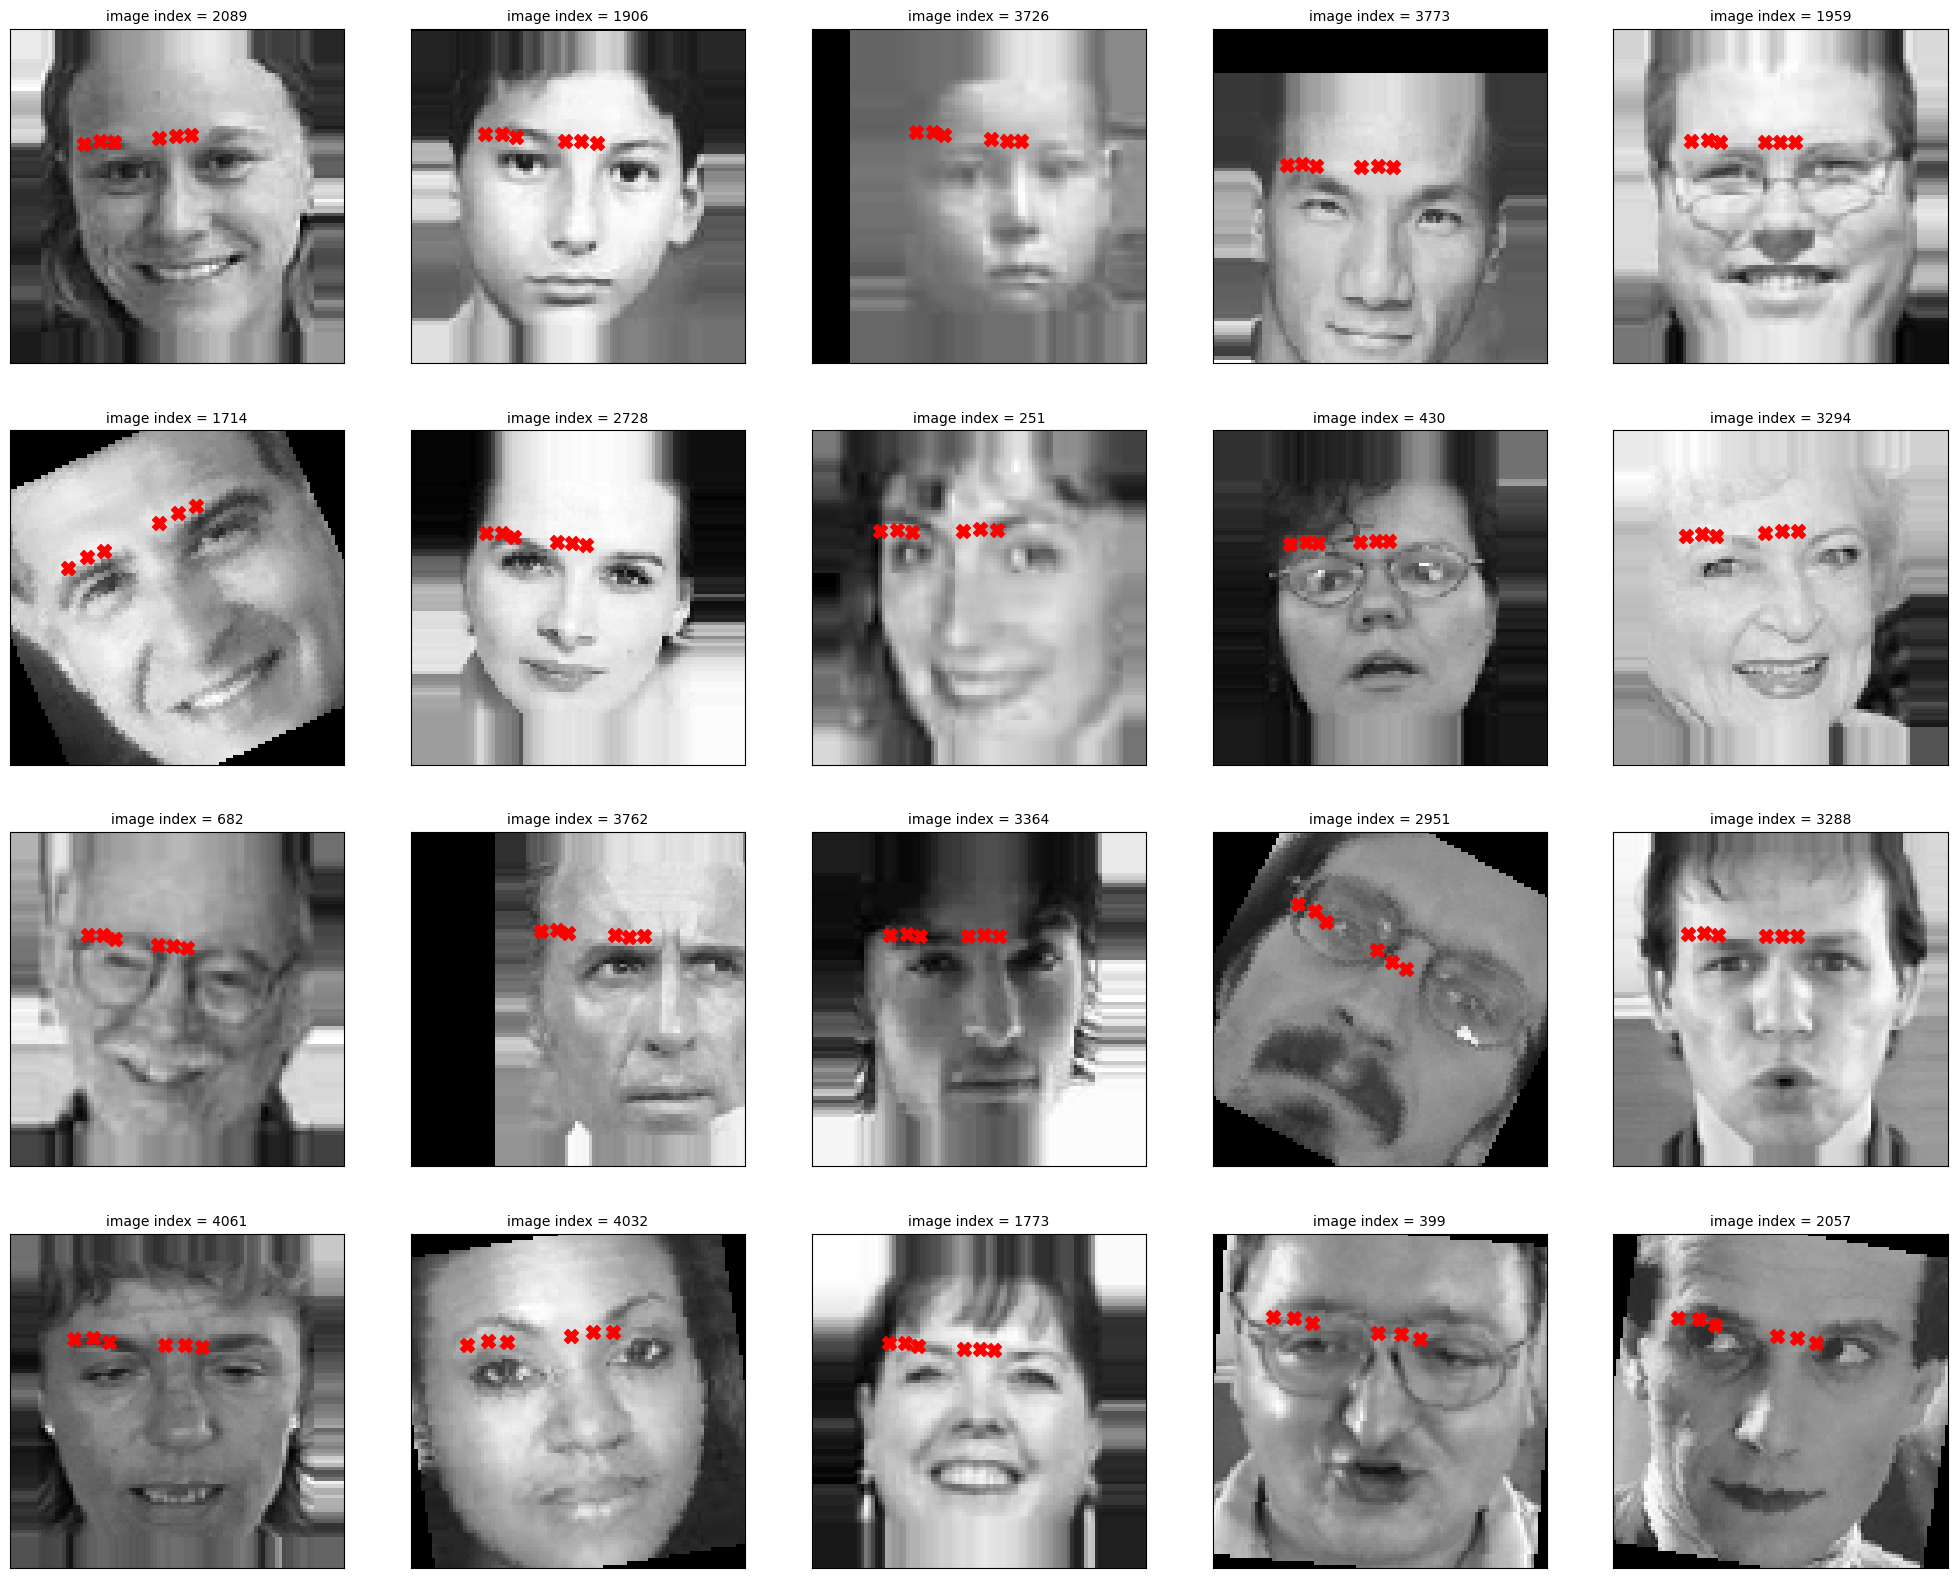

In [17]:
Y_pred = model.predict(X_test)

plot_sample(X_test, Y_pred, 4, 5, 5)

Test the model on CASIA-Iris-Distance dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
[[49.955055 29.572594 22.836123 28.20721  44.202896 29.73824  55.0297
  30.032639 27.636345 29.041664 17.278961 28.56486 ]]


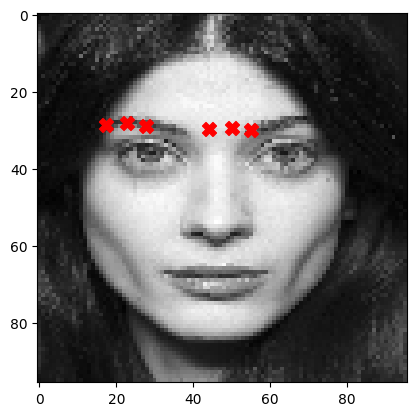

In [18]:
test_image = cv2.imread('./dataset/test_face.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[47.767143 27.117882 24.990387 27.828754 42.93477  27.689692 52.169277
  27.115995 29.133213 28.263308 20.318493 28.331905]]


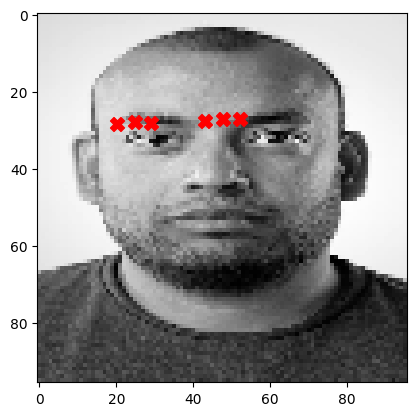

In [19]:
test_image = cv2.imread('./dataset/test_face_2.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[51.518085 30.22134  22.769726 29.692633 45.34987  30.668385 56.86553
  30.601746 27.806065 30.406912 16.860598 30.222359]]


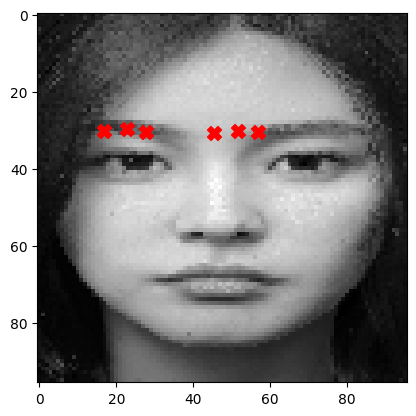

In [20]:
test_image = cv2.imread('./dataset/test_face_3.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()